In [1]:
import torch
from torchvision.datasets import FashionMNIST
fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

In [2]:
train_input = fm_train.data
train_target = fm_train.targets

In [3]:
train_scaled = train_input / 255.0

In [4]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target
)

In [5]:
import torch.nn as nn
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100,10),
)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 맥: device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [8]:
train_hist = []
val_hist = []

patience = 3
best_loss = -1
erly_stopping_count = 0
epochs = 50
batches = int(len(train_scaled)/32)
for epoch in range(epochs):
    model.train()
    train_loss = 0.0 # 에포크 당 평균 손실
    for i in range(batches): # 미니 배치
        inputs = train_scaled[i*32:(i+1)*32].to(device)
        targets = train_target[i*32:(i+1)*32].to(device)

        optimizer.zero_grad() # 그래디언트 연산 초기화
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step() # 모델 업데이트

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        val_scaled = val_scaled.to(device)
        val_target = val_target.to(device)
        outputs = model(val_scaled)
        val_loss = criterion(outputs, val_target).item()
        val_loss = loss.item()
    
    train_loss_avg = train_loss / batches
    train_hist.append(train_loss_avg) # 1에포크 훈련세트 손실값 평균
    val_hist.append(val_loss)  # 1에포크 검증 손실값

    print(f'에포크 {epoch+1}, 훈련 손실: {train_loss:.4f}, 검증 손실: {val_loss:.4f}')

    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        erly_stopping_count = 0
        torch.save(model.state_dict(), 'best-model.pt')
    else:
        erly_stopping_count += 1
        if erly_stopping_count >= patience:
            print("조기 종료")
            break

에포크 1, 훈련 손실: 855.7517, 검증 손실: 0.4939
에포크 2, 훈련 손실: 627.1466, 검증 손실: 0.4111
에포크 3, 훈련 손실: 573.7343, 검증 손실: 0.3754
에포크 4, 훈련 손실: 537.8771, 검증 손실: 0.4760
에포크 5, 훈련 손실: 515.3269, 검증 손실: 0.4268
에포크 6, 훈련 손실: 500.1042, 검증 손실: 0.4441
조기 종료


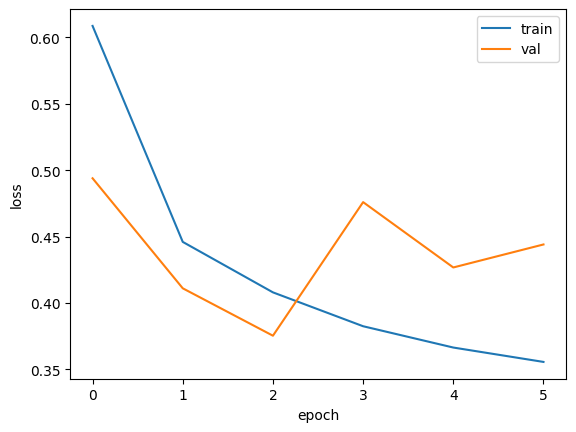

In [9]:
import matplotlib.pyplot as plt
        
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100,10),
)

In [11]:
with torch.no_grad():
    val_scaled = val_scaled.to(device)
    val_target = val_target.to(device)
    outputs = model(val_scaled)
    val_loss = criterion(outputs, val_target).item()
    predicts = torch.argmax(outputs, 1)
    corrects = (predicts == val_target).sum().item()

accuracy = corrects / len(val_target)
print(f"검증세트 정확도:{accuracy:.4f}, 손실값:{loss.item():.4f}")

검증세트 정확도:0.1386, 손실값:0.4441
